In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Technical Analysis in Python

## Creating a Candlestick Chart

In [3]:
import pandas as pd 
import yfinance as yf
import datetime

In [4]:
# !pip uninstall matplotlib

In [5]:
# !pip install matplotlib==3.2.2

In [6]:
# !pip install plotly --upgrade
# !pip install cufflinks --upgrade

In [11]:
df_twtr = yf.download('TWTR', 
                       start='2018-01-01', 
                       end='2018-12-31',
                       progress=False,
                       auto_adjust=True)

In [7]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
# import plotly.offline as pyo
# import plotly.graph_objs as go
# pyo.init_notebook_mode()

init_notebook_mode()

In [8]:
# !pip install chart_studio

In [9]:
import chart_studio
chart_studio.tools.set_credentials_file(username='sebals38', api_key='cbCdFYwWTQkiW0nuX9Sv')

In [13]:
qf = cf.QuantFig(df_twtr, title="Twitter's Stock Price", 
                 legend='top', name='TWTR')

In [14]:
qf.add_volume()
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')

In [15]:
qf.iplot()

## Backtesting a Strategy Based on Simple Moving Average

In [16]:
# !pip install backtrader

In [17]:
import backtrader as bt

In [18]:
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [19]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31'))

# <original>
# data = bt.feeds.YahooFinanceData(dataname='AAPL', 
#                                  fromdate=datetime.datetime(2018, 1, 1), 
#                                  todate=datetime.datetime(2018, 12, 31))

[*********************100%***********************]  1 of 1 completed


In [20]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [21]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1002.61


<IPython.core.display.Javascript object>


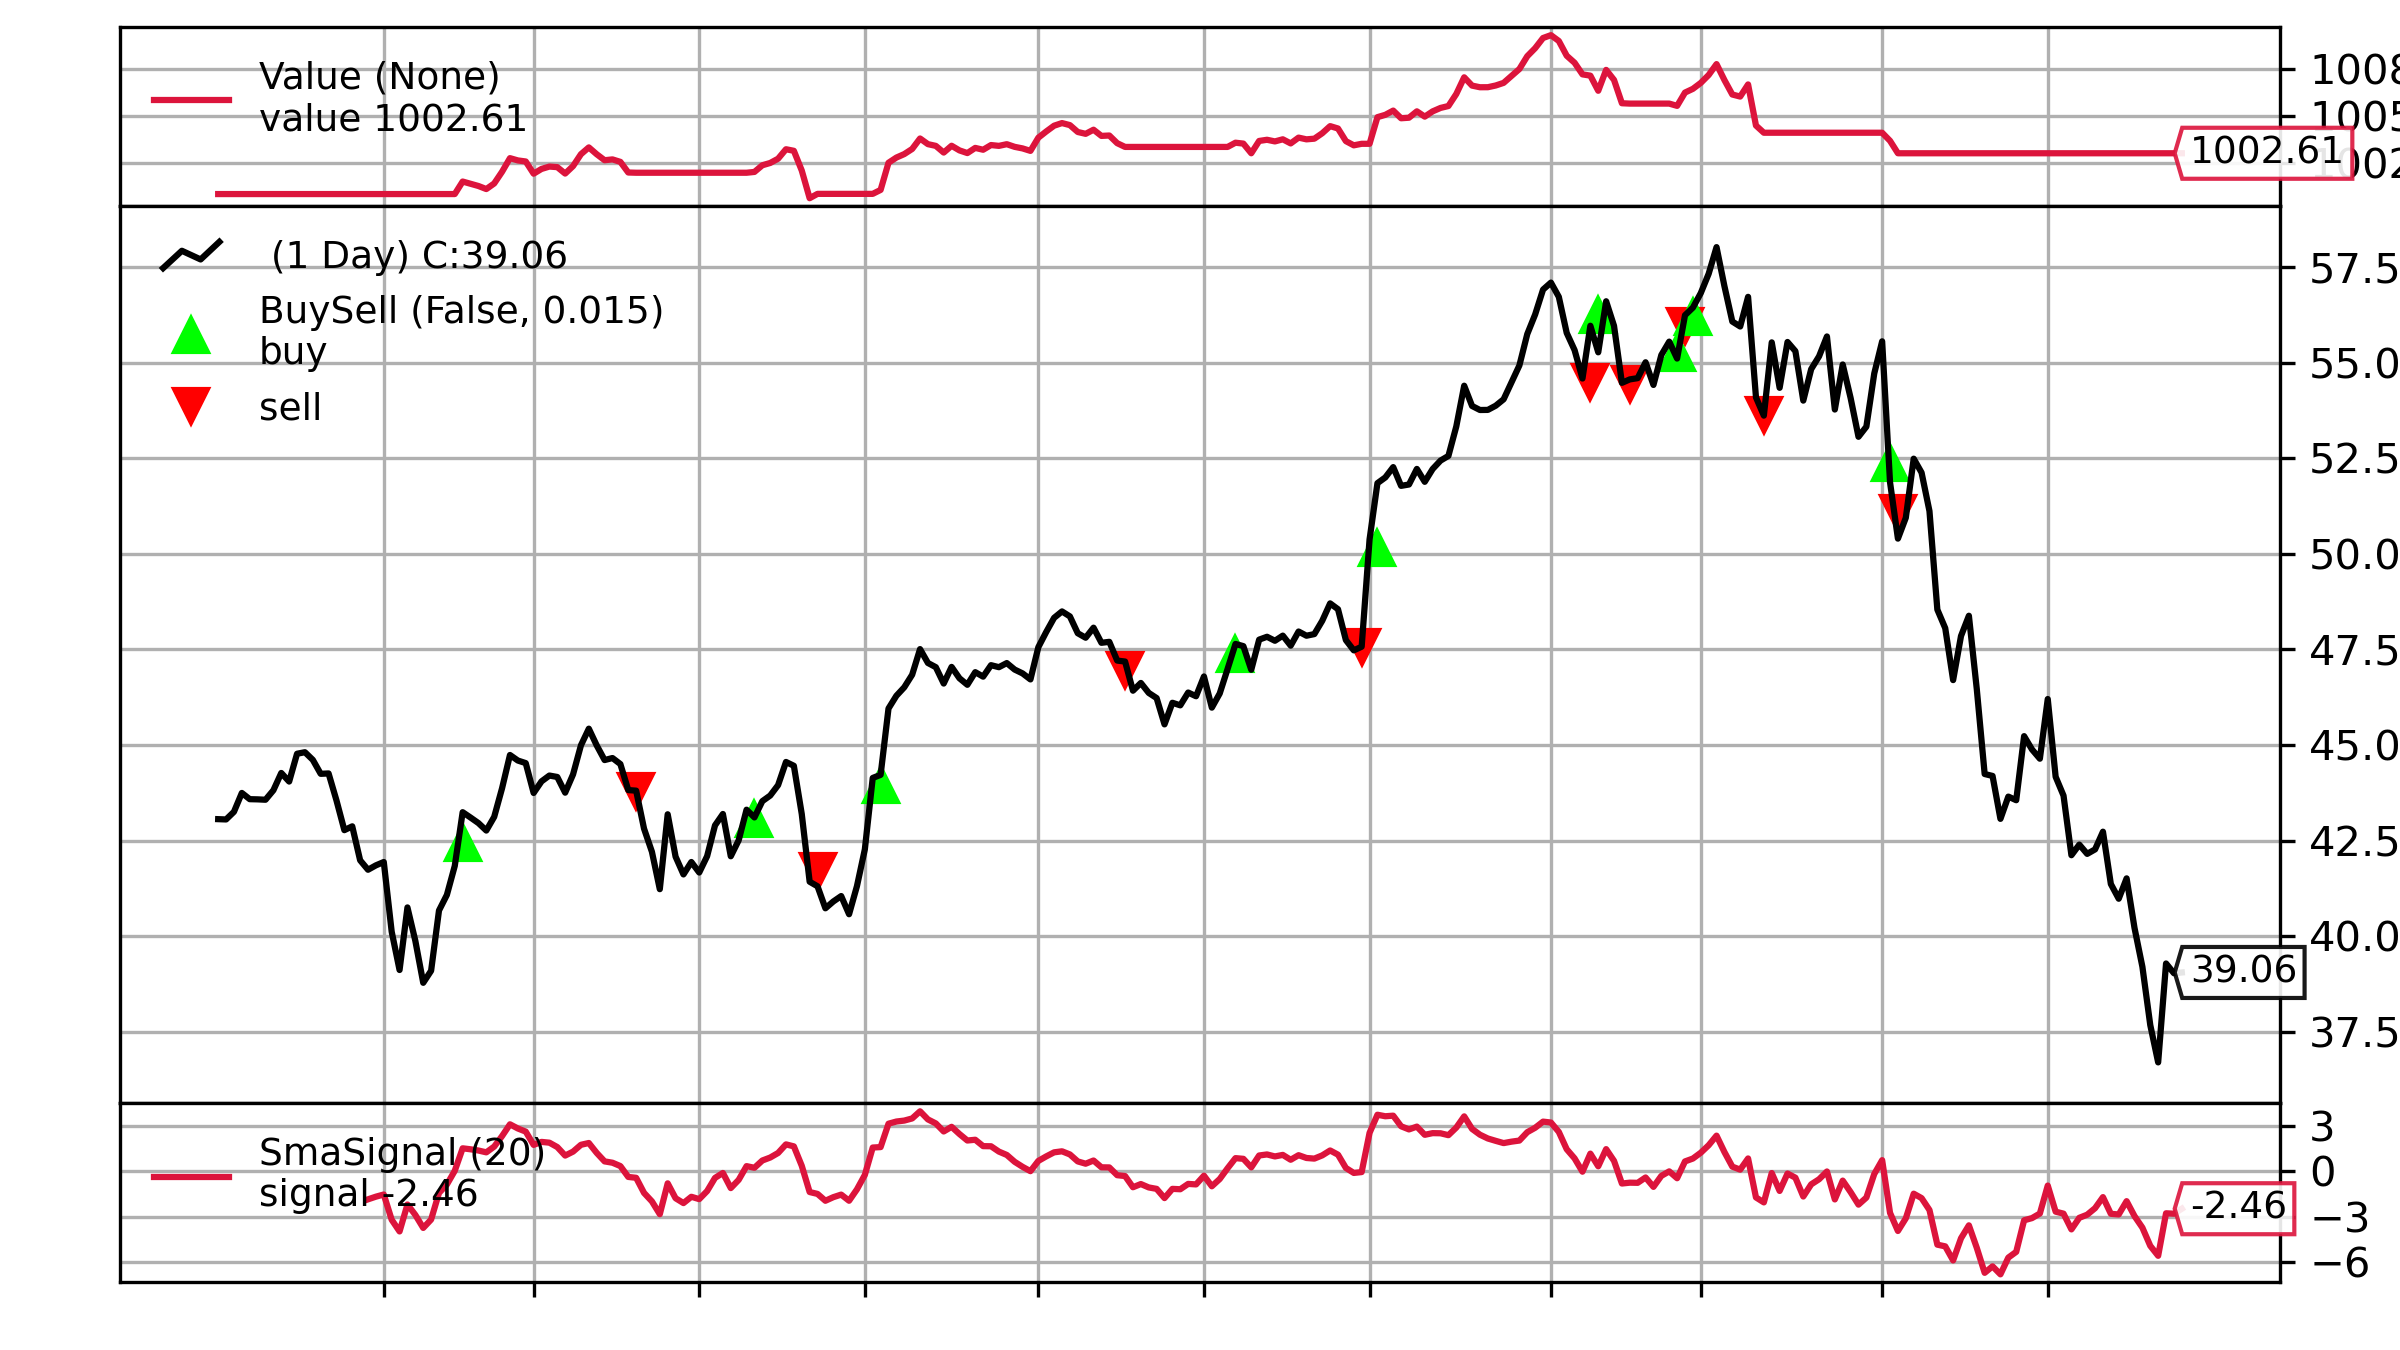

[[<Figure size 2400x1350 with 3 Axes>]]

In [22]:
cerebro.plot(iplot=True, volume=False, figsize=(10, 5))
# plt.figure(figsize=(10, 5))

## strategy

In [27]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [28]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [29]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue(): .2f}')
cerebro.run()
print(f'Final Portfolio Value : {cerebro.broker.getvalue(): .2f}')

Starting Portfolio Value:  1000.00
2018-02-14, BUY CREATED --- Price: 41.84
2018-02-15, BUY EXECUTED --- Price: 42.45, Cost: 42.45, Commission: 0.00
2018-03-19, SELL CREATED --- Price: 43.83
2018-03-20, SELL EXECUTED --- Price: 43.81, Cost: 42.45, Commission: 0.00
2018-03-20, OPERATION RESULT --- Gross: 1.36, Net: 1.36
2018-04-10, BUY CREATED --- Price: 43.31
2018-04-11, BUY EXECUTED --- Price: 43.06, Cost: 43.06, Commission: 0.00
2018-04-20, SELL CREATED --- Price: 41.43
2018-04-23, SELL EXECUTED --- Price: 41.71, Cost: 43.06, Commission: 0.00
2018-04-23, OPERATION RESULT --- Gross: -1.35, Net: -1.35
2018-05-02, BUY CREATED --- Price: 44.14
2018-05-03, BUY EXECUTED --- Price: 43.97, Cost: 43.97, Commission: 0.00
2018-06-15, SELL CREATED --- Price: 47.21
2018-06-18, SELL EXECUTED --- Price: 46.97, Cost: 43.97, Commission: 0.00
2018-06-18, OPERATION RESULT --- Gross: 3.00, Net: 3.00
2018-07-06, BUY CREATED --- Price: 46.99
2018-07-09, BUY EXECUTED --- Price: 47.38, Cost: 47.38, Commissi

### 변수 최적화

In [ ]:
import yfinance as yf
from datetime import datetime
import backtrader as bt

class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )
    
    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date[0].isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        self.order = None
        
    def next(self):
        if self.order:
            return
        
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()
                
    def stop(self):
        self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value : {self.broker.get_value():.2f}')
        
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31'))

cerebro = bt.Cerebro(stdstats=False)

cerebro.adddata(data)
cerebro.optstrategy(SmaStrategy, ma_period=range(10, 31))
cerebro.broker.setcash(10000)
cerebro.run(maxcpus=4)

[*********************100%***********************]  1 of 1 completed
